In [9]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, sys, numpy as np

%matplotlib inline

In [10]:
# add main directory to path in order to import other parts of the shelter animal outcomes project
sys.path.extend(['/Users/pc3sq/Google Drive/Data Science Library/!notebooks/shelter animal outcomes kaggle/'])

from src import pipeline

Initially I felt there were too many unique colors and I was unsure what to extract from it to keep the number of dimensions down. The current model has a log loss of ~0.85 and ranks around the top 50% on Kaggle. I felt it necessary to revisit what we might extract from the Color column to improve on our log loss.

In [11]:
clean = pd.read_csv('../data/shelter-clean.csv')

# <center>Dog Colors</center>

In [4]:
# unique colors for dogs
dogs = clean[clean['AnimalType']=='Dog']
dog_colors = dogs['Color'].unique()
# dog_colors

The string values of the Color column contain the following colors and coats described in the [Dog Coat Wiki](https://en.wikipedia.org/wiki/Coat_(dog)#Nomenclature_of_colors_and_patterns):

Colors:
+ Brown, Chocolate, Liver
+ Red, Orange, Brown, Tan
+ Gold, Yellow, Buff - placing buff here with gold and yellow is based on what I saw
+ Cream
+ Fawn - a yellow, tan, light brown, or cream dog that has a dark melanistic mask, Ex. most pugs have this
+ Black
+ Blue
+ Gray
+ White

Patterns - caused by alleles:
+ Tick - flecks or spots of colour on white areas
+ Brindle - a brownish or tawny color of animal fur, with streaks of other color
+ Merle - patches, Ex. [Blue Merle Border Collie Puppy](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/BorderColliePupTheEye_wb.jpg/440px-BorderColliePupTheEye_wb.jpg)
+ Agouti - allele affecting distribution of black pigment
+ Tiger
+ Tricolor

Multi-colored - contains multiple colors:
+ Any color value with a "/" is considered "multi" colored
+ Any color value without is considered "solid" colored

Knowing that certain colors may be grouped together such as brown, chocolate, and liver may help reduce the number of dimensions for the features extracted from Color but I'm not certain of any value added by extracting these color groups as a feature.

It would be more helpful if we knew if certain colors were more popular than others, ease to maintenance, etc. for it to be useful. A quick note on extracting popularity from Color ... Popularity is subject to trends. Brindle might be popular one year and tuxedo the next. Popularity may even be seasonal. Without a time series dataset on the popularity of colors and patterns, it will be hard to extract popularity from Color. Popularity is also potentially too subjective to have any meaning. We would need a popularity metric measured by something objective like total puppies sold or price average by color/pattern.

In [84]:
# peparing dog colors for plot
dog_color_counts = dogs['Color'].value_counts()

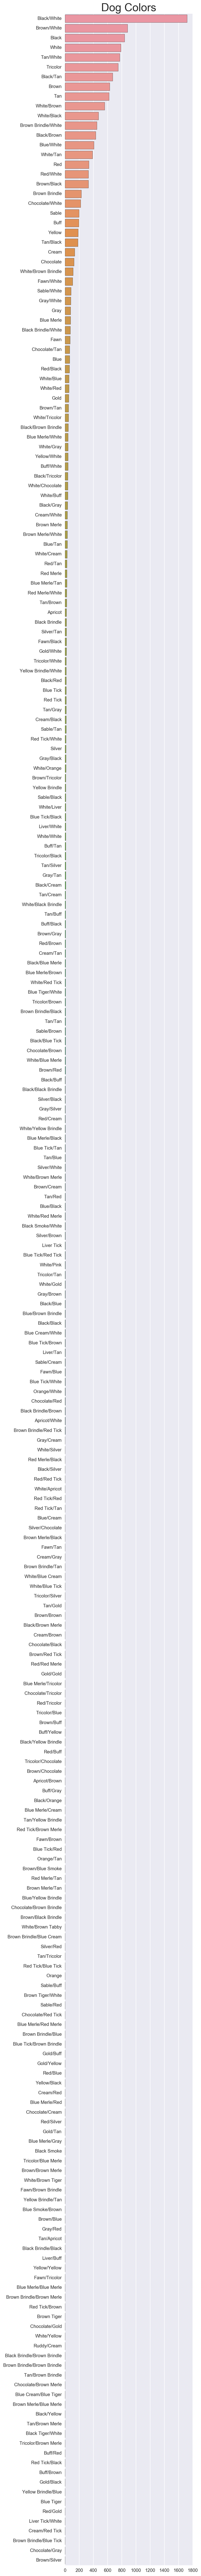

In [72]:
sns.set # matplotlib defaults

rc={'figure.figsize': (5, 100), 'axes.labelsize': 24, 'font.size': 30., 'legend.fontsize': 20.0,\
    'axes.titlesize': 14}

plt.rcParams.update(**rc)
    
%config InlineBackend.figure_format = 'retina'

# dog_colors_countplot = sns.countplot(y=dogs['Color'])
# dog_colors_countplot.set_title('Dog Colors', fontsize=24)

## couldn't figure out how to sort dog color value counts so created barplot instead
dog_color_barplot = sns.barplot(y=dog_color_counts.index, x=dog_color_counts.values)
dog_color_barplot.set_title('Dog Colors', fontsize=24)

In [74]:
# # saving dogs_by_color count plot
# dcc_fig = dog_color_barplot.get_figure()
# dcc_fig.savefig("../figures/dogs_by_color.png")

## "Other" Colored Dogs

In [8]:
# if we create an "other" category for low count colors, we can reduce # of dummy variables
dog_color_thresh = 100.

print "# of dog colors: ", len(dog_colors)
print "Dog colors w/ < %d count: %d" %(dog_color_thresh, sum(dogs['Color'].value_counts() < dog_color_thresh))
print "Dog dataset reduced by: ", dog_color_thresh / len(dog_colors)
print "# dimensions remaining: ", len(dog_colors) - sum(dogs['Color'].value_counts() < dog_color_thresh) + 1

# of dog colors:  262
Dog colors w/ < 100 count: 234
Dog dataset reduced by:  0.381679389313
# dimensions remaining:  29


## Patterned vs. Non-Patterned Dogs

In [9]:
dog_patterns = ['Tick', 'Brindle', 'Merle ', 'Agouti', 'Tiger ', 'Tricolor']

In [75]:
# identify dog colors that are patterned
dog_colors_with_patterns = set([color for pattern in dog_patterns for color in dog_colors if pattern in color])

In [76]:
# # extract 1 if Patterned else 0 from dogs['Color']
# dogs['Color'].apply(lambda color: 1 if color in dog_colors_with_patterns else 0)

In [78]:
# 13% of dogs are patterned
sum(dogs['Color'].apply(lambda color: 1 if color in dog_colors_with_patterns else 0)) / float(dogs.shape[0])

0.13075435203094776

## Solid vs. Multi-Colored Dogs

In [80]:
# identify dog colors without a "/"
no_slash_dog_colors = [c for c in dog_colors if "/" not in c]

# Are all dog colors without a slack considered solid colored? 
# Should we remove 'Tricolor', for example?
no_slash_dog_colors

['Tan',
 'White',
 'Silver',
 'Brown',
 'Black',
 'Yellow',
 'Tricolor',
 'Buff',
 'Red',
 'Brown Brindle',
 'Gray',
 'Blue Merle',
 'Sable',
 'Cream',
 'Chocolate',
 'Fawn',
 'Blue',
 'Apricot',
 'Yellow Brindle',
 'Gold',
 'Blue Tick',
 'Red Merle',
 'Black Brindle',
 'Brown Merle',
 'Red Tick',
 'Liver Tick',
 'Blue Tiger',
 'Orange',
 'Brown Tiger',
 'Black Smoke']

In [81]:
# remove "Tricolor" as a solid dog color
solid_dog_colors = [color for color in no_slash_dog_colors if color != 'Tricolor']
"Tricolor" not in solid_dog_colors

True

In [83]:
# # extract 1 if Multi-Colored dog else 0 from dogs['Color']
# dogs['Color'].apply(lambda color: 1 if color not in solid_dog_colors else 0)

## Dog Colors Summary

It looks like we can extract at least the following features from dog colors:

+ Color Groups - grouping certain colors together for group colors to reduce color dimensionality
+ "other" color value - create an "others" color category to group all the low count colors
+ Patterned - extract a patterned feature for patterned vs. non-patterned
+ Multi-Colored feature - extract a multi-colored feature for solid vs. multi-colored

We should always go from the most generalized to the most granular features we can extract in order to keep our dimensional space low. Therefore, I propose we extract the features Patterned and Multi-Colored first before we consider extracting Color Groups and combining low count colors into an "others" value. This will keep our dimensional space from multiplying into the hundreds.

Also, since dogs and cats share this dataset, it would keep our dimensional space low if we can extract overlapping features between dogs and cats. I believe Patterned and Multi-Colored are common features between them. 

Let's see if the cats also have a Patterned feature and a Multi-Colored feature we can extract.

# <center>Cat Colors</center>

In [12]:
cats = clean[clean['AnimalType']=='Cat']
cat_colors = cats['Color'].unique()
cat_colors

array(['Cream Tabby', 'Blue Cream', 'Blue Tabby', 'Orange Tabby/White',
       'Brown Tabby', 'White', 'Orange Tabby', 'Cream Tabby/White', 'Blue',
       'Calico', 'Torbie', 'Blue/White', 'Black/White', 'White/Black',
       'Black', 'Tortie', 'Blue Tabby/White', 'Flame Point',
       'Brown Tabby/White', 'Black Tabby/White', 'Tortie/Calico',
       'White/Cream Tabby', 'White/Blue Tabby', 'Blue Point', 'Seal Point',
       'White/Brown Tabby', 'Lynx Point/White', 'Lilac Point',
       'White/Orange Tabby', 'Tortie Point', 'Lynx Point', 'Tortie/White',
       'Cream', 'Gray Tabby', 'White/Blue', 'Torbie/White',
       'Black Smoke/White', 'Blue Tabby/Orange', 'Chocolate',
       'Black Smoke', 'Calico Point', 'Gray/White', 'Tricolor',
       'Tortie Point/Lynx Point', 'Calico/White', 'Black Tabby',
       'White/Chocolate Point', 'Calico Point/White', 'Seal Point/White',
       'Calico/Brown Tabby', 'Silver Tabby', 'Black/Orange',
       'Chocolate Point/White', 'Tortie/Blue Cream', '

The [Cat Coat Wiki](https://en.wikipedia.org/wiki/Cat_coat_genetics) didn't offer any real color groupings so the following represents only coat patterns for cats: 

Patterns - caused by alleles (check marks indicate shared color characteristic with dogs):
+ Agouti - allele affecting distribution of black pigment ✓
+ Tiger ✓
+ Tricolor ✓
+ Smoke (seems like a sort after rarity)
+ Tabby (distinctive stripes, dots, lines or swirling patterns, usually together with a mark resembling an 'M' on its forehead)
+ Lynx (formed by cross-breeding a colorpoint cat with a tabby cat)
+ Point (aka Colorpoint, dark pigmentation limited to the coldest areas of the body, quintessential example being a Siamese)
+ Calico (patchwork)
+ Tortie - tortoise shell
+ Torbie - tortoise and tabby mix

As with the dogs, we can use "/" to separate the solid colored cats from the multi-colored.

Multi-colored - contains multiple colors:
+ Any color value with a "/" is considered "multi" colored
+ Any color value without is considered "solid" colored

In [15]:
# preparing cat colors for plot
cat_color_counts = cats['Color'].value_counts()

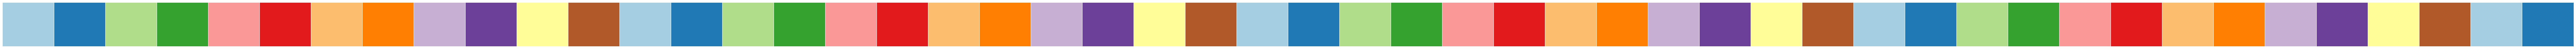

In [14]:
# playing with seaborn colors
# referenced https://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html
sns.palplot(sns.color_palette("Paired", n_colors=50), size=2)

In [29]:
sns.set # matplotlib defaults

rc={'figure.figsize': (12, 100), 'axes.labelsize': 24, 'font.size': 30., 'legend.fontsize': 20.0,\
    'axes.titlesize': 14}

plt.rcParams.update(**rc)
    
%config InlineBackend.figure_format = 'retina'

ccb = cat_color_barplot = sns.barplot(y=cat_color_counts.index, x=cat_color_counts.values, palette=sns.color_palette("Paired", n_colors=50))
ccb.set_title('Cat Colors', fontsize=45, fontweight='bold', y=1.007)
ccb.tick_params(axis='both', labelsize=12)
ccb.xaxis.set_ticks_position('top')
ccb.set_xlabel('number of cats', fontsize=10)
ccb.xaxis.set_label_position('top')

for x,y in zip(cat_color_counts.index, cat_color_counts.values):
    ccb.text(x=x, y=y, s=y)

# # figuring out how to have count value show up at the end of the bar
# for p in ccb.patches:
#     ccb.annotate(str(p.get_height()), (p.get_y() * 1.005, p.get_height() * 1.005))

Error in callback <function post_execute at 0x1123647d0> (for post_execute):


ValueError: could not convert string to float: Brown Tabby

ValueError: could not convert string to float: Brown Tabby

In [30]:
# len(ccb.patches) == len(cats['Color'].unique()) # True
test_patch = ccb.patches[0]


In [31]:
test_patch.

AttributeError: 'Rectangle' object has no attribute 'methods'

In [ ]:
# # saving cats_by_color count plot
ccb_fig = cat_color_barplot.get_figure()
# ccb_fig.savefig("../figures/cats_by_color.svg", format='svg', dpi=1200)
ccb_fig.savefig("../figures/cats_by_color.png", dpi=1200)

In [117]:
# quick view of top colors
cats['Color'].value_counts()[:20]

Brown Tabby           1454
Black                 1248
Black/White            978
Brown Tabby/White      845
Orange Tabby           764
Tortie                 511
Calico                 498
Orange Tabby/White     431
Blue Tabby             401
Blue                   352
Torbie                 321
Blue/White             261
Blue Tabby/White       220
Cream Tabby            183
Lynx Point             160
White/Black            143
Seal Point             125
White                  107
White/Brown Tabby       84
Flame Point             83
Name: Color, dtype: int64

## "Other" Colored Cats

In [118]:
# if we create an "other" category for low count cat colors, we can reduce # of dummy variables
# but I feel there are still too many color groupings; let's avoid color grouping features for now
cat_color_thresh = 20.

print "# of cat colors: ", len(dog_colors)
print "Cat colors w/ < %d count: %d" %(cat_color_thresh, sum(cats['Color'].value_counts() < cat_color_thresh))
print "Cat dataset reduced by: ", cat_color_thresh / len(cat_colors)
print "# dimensions remaining: ", len(cat_colors) - sum(cats['Color'].value_counts() < cat_color_thresh) + 1

# of cat colors:  262
Cat colors w/ < 20 count: 106
Cat dataset reduced by:  0.142857142857
# dimensions remaining:  35


## Patterned vs. Non-Patterned Cats

In [119]:
cat_patterns = ['Agouti', 'Tiger', 'Tricolor','Smoke', 'Tabby', 'Lynx', 'Point', 'Calico', 'Tortie', 'Torbie']

In [120]:
cat_colors_with_patterns = set([color for pattern in cat_patterns for color in cat_colors if pattern in color])

In [121]:
# extract Patterned from Color
cats['Color'].apply(lambda color: 1 if color in cat_colors_with_patterns else 0)

1        1
3        0
6        1
13       1
14       1
16       0
19       0
23       1
26       1
27       0
28       1
30       1
35       0
36       0
37       1
38       1
39       1
40       1
41       0
42       0
44       0
45       0
48       1
49       1
50       1
52       1
53       0
54       1
58       1
60       0
        ..
25543    0
25546    0
25547    1
25552    1
25554    0
25557    1
25560    1
25562    1
25567    1
25568    1
25570    0
25572    1
25576    1
25577    1
25578    1
25583    1
25587    1
25588    1
25589    0
25590    1
25591    0
25597    1
25598    1
25603    1
25604    0
25605    1
25607    1
25608    1
25610    0
25611    1
Name: Color, dtype: int64

In [122]:
cat_colors_with_patterns

{'Agouti',
 'Agouti/Brown Tabby',
 'Black Smoke',
 'Black Smoke/Brown Tabby',
 'Black Smoke/White',
 'Black Tabby',
 'Black Tabby/Orange',
 'Black Tabby/White',
 'Black Tiger/White',
 'Black/Black Smoke',
 'Black/Black Tabby',
 'Black/Silver Tabby',
 'Blue Cream/Blue Tabby',
 'Blue Cream/Tortie',
 'Blue Point',
 'Blue Point/White',
 'Blue Smoke',
 'Blue Tabby',
 'Blue Tabby/Blue Cream',
 'Blue Tabby/Cream',
 'Blue Tabby/Orange',
 'Blue Tabby/Tan',
 'Blue Tabby/White',
 'Blue/Tortie',
 'Brown Tabby',
 'Brown Tabby/Black',
 'Brown Tabby/Brown',
 'Brown Tabby/Gray',
 'Brown Tabby/Gray Tabby',
 'Brown Tabby/Orange',
 'Brown Tabby/Tortie',
 'Brown Tabby/White',
 'Brown Tiger',
 'Brown/Black Tabby',
 'Calico',
 'Calico Point',
 'Calico Point/White',
 'Calico/Black',
 'Calico/Blue Cream',
 'Calico/Blue Tabby',
 'Calico/Brown',
 'Calico/Brown Tabby',
 'Calico/Orange Tabby',
 'Calico/Tricolor',
 'Calico/White',
 'Chocolate Point',
 'Chocolate Point/White',
 'Chocolate/Black Smoke',
 'Cream Tabb

## Solid vs. Multi-colored Cats

In [123]:
# is having no slash enough to extract only solid colors? doesn't appear so
no_slash_cat = [c for c in cat_colors if "/" not in c]

# should we remove 'Tobie', 'Tortie', 'Calico', as solid colors?
no_slash_cat

['Cream Tabby',
 'Blue Cream',
 'Blue Tabby',
 'Brown Tabby',
 'White',
 'Orange Tabby',
 'Blue',
 'Calico',
 'Torbie',
 'Black',
 'Tortie',
 'Flame Point',
 'Blue Point',
 'Seal Point',
 'Lilac Point',
 'Tortie Point',
 'Lynx Point',
 'Cream',
 'Gray Tabby',
 'Chocolate',
 'Black Smoke',
 'Calico Point',
 'Tricolor',
 'Black Tabby',
 'Silver Tabby',
 'Orange',
 'Brown Tiger',
 'Agouti',
 'Gray',
 'Blue Smoke',
 'Chocolate Point',
 'Silver Lynx Point',
 'Tan',
 'Silver',
 'Buff',
 'Orange Tiger',
 'Brown']

In [124]:
# create final set of solid cat colors by removing 'Tobie', 'Tortie', and 'Calico'
solid_cat_colors = sorted([name for name in no_slash if name not in  ['Tobie', 'Tortie', 'Calico']])

NameError: name 'no_slash' is not defined

In [ ]:
# there are enough solid colored cats to consider extracting a solid vs. multi-colored feature from Color
print sum(cats['Color'].apply(lambda color: True if color in solid_cat_colors else False)) / float(cats.shape[0])

In [ ]:
# extract 1 if Multi-colored 0 if Solid from cats['Color']
cats['Color'].apply(lambda color: 1 if color not in solid_cat_colors else 0)

# Conclusion: Extract Patterned and Multi-Colored

At this point, I will extract a Patterned and a Multi-colored feature. I will reduce Color with an "other" value to reduce the dimensionality of a dummified Color column if needed.

In [ ]:
# extract 1 if Patterned else 0 from dogs['Color']
{'Black Brindle',
 'Black Brindle/Black',
 'Black Brindle/Brown',
 'Black Brindle/Brown Brindle',
 'Black Brindle/White',
 'Black/Black Brindle',
 'Black/Blue Tick',
 'Black/Brown Brindle',
 'Black/Tricolor',
 'Black/Yellow Brindle',
 'Blue Merle/Tricolor',
 'Blue Tick',
 'Blue Tick/Black',
 'Blue Tick/Brown',
 'Blue Tick/Brown Brindle',
 'Blue Tick/Red',
 'Blue Tick/Red Tick',
 'Blue Tick/Tan',
 'Blue Tick/White',
 'Blue/Brown Brindle',
 'Blue/Yellow Brindle',
 'Brown Brindle',
 'Brown Brindle/Black',
 'Brown Brindle/Blue',
 'Brown Brindle/Blue Cream',
 'Brown Brindle/Blue Tick',
 'Brown Brindle/Brown Brindle',
 'Brown Brindle/Brown Merle',
 'Brown Brindle/Red Tick',
 'Brown Brindle/Tan',
 'Brown Brindle/White',
 'Brown/Black Brindle',
 'Brown/Red Tick',
 'Brown/Tricolor',
  'Chocolate/Brown Brindle',
 'Chocolate/Red Tick',
 'Chocolate/Tricolor',
 'Cream/Red Tick',
 'Fawn/Brown Brindle',
 'Fawn/Tricolor',
 'Liver Tick',
 'Liver Tick/White',
 'Red Tick',
 'Red Tick/Black',
 'Red Tick/Blue Tick',
 'Red Tick/Brown',
 'Red Tick/Brown Merle',
 'Red Tick/Red',
 'Red Tick/Tan',
 'Red Tick/White',
 'Red/Red Tick',
 'Red/Tricolor',
 'Tan/Brown Brindle',
 'Tan/Tricolor',
 'Tan/Yellow Brindle',
 'Tricolor',
 'Tricolor/Black',
 'Tricolor/Blue',
 'Tricolor/Blue Merle',
 'Tricolor/Brown',
 'Tricolor/Brown Merle',
 'Tricolor/Chocolate',
 'Tricolor/Silver',
 'Tricolor/Tan',
 'Tricolor/White',
 'White/Black Brindle',
 'White/Blue Tick',
  'White/Brown Brindle',
 'White/Red Tick',
 'White/Tricolor',
 'White/Yellow Brindle',
 'Yellow Brindle',
 'Yellow Brindle/Blue',
 'Yellow Brindle/Tan',
 'Yellow Brindle/White'} 
 
dogs['Color'].apply(lambda color: 1 if color in dog_colors_with_patterns else 0)

In [ ]:
# extract 1 if Multi-Colored dog else 0 from dogs['Color']
['Tan',
 'White',
 'Silver',
 'Brown',
 'Black',
 'Yellow',
 'Buff',
 'Red',
 'Brown Brindle',
 'Gray',
 'Blue Merle',
 'Sable',
 'Cream',
 'Chocolate',
 'Fawn',
 'Blue',
 'Apricot',
 'Yellow Brindle',
 'Gold',
 'Blue Tick',
 'Red Merle',
 'Black Brindle',
 'Brown Merle',
 'Red Tick',
 'Liver Tick',
 'Blue Tiger',
 'Orange',
 'Brown Tiger',
 'Black Smoke']


dogs['Color'].apply(lambda color: 1 if color not in solid_dog_colors else 0)

In [ ]:
# extract 1 if Patterned else 0 from cats['Color']
{'Agouti',
'Agouti/Brown Tabby',
'Brown Tiger',
'Black Tiger/White',
'Orange Tiger',
'Tricolor',
'Calico/Tricolor',
'Tricolor/Calico',
'Black Smoke/White',
'Black Smoke',
'Blue Smoke',
'Black/Black Smoke',
'Black Smoke/Brown Tabby',
'Chocolate/Black Smoke',
'White/Black Smoke',
'Tortie/Black Smoke',
'Cream Tabby',
'Blue Tabby',
'Orange Tabby/White',
'Brown Tabby',
'Orange Tabby',
'Cream Tabby/White',
'Blue Tabby/White',
'Brown Tabby/White',
'Black Tabby/White',
'White/Cream Tabby',
'White/Blue Tabby',
'White/Brown Tabby',
'White/Orange Tabby',
'Gray Tabby',
'Blue Tabby/Orange',
'Black Tabby',
'Calico/Brown Tabby',
'Silver Tabby',
'White/Black Tabby',
'Black/Silver Tabby',
'Blue Tabby/Blue Cream',
'Brown Tabby/Black',
'Gray Tabby/White',
'Black Tabby/Orange',
'Silver Tabby/White',
'Black Smoke/Brown Tabby',
'Blue Tabby/Tan',
'Black/Black Tabby',
'Brown Tabby/Gray',
'Brown/Black Tabby',
'Lynx Point/Brown Tabby',
'Orange Tabby/Black',
'Brown Tabby/Brown',
'White/Gray Tabby',
'Calico/Orange Tabby',
'Agouti/Brown Tabby',
'Brown Tabby/Tortie',
'Lynx Point/Gray Tabby',
'Blue Tabby/Cream',
'Silver Tabby/Black',
'Orange Tabby/Orange',
'Brown Tabby/Orange',
'Blue Cream/Blue Tabby',
'Calico/Blue Tabby',
'Brown Tabby/Gray Tabby',
'Lynx Point/White',
'Lynx Point',
'Tortie Point/Lynx Point',
'White/Lynx Point',
'Lynx Point/Brown Tabby',
'Silver Lynx Point',
'Lynx Point/Gray Tabby',
'Flame Point',
'Blue Point',
'Seal Point',
'Lynx Point/White',
'Lilac Point',
'Tortie Point',
'Lynx Point',
'Calico Point',
'Tortie Point/Lynx Point',
'White/Chocolate Point',
'Calico Point/White',
'Seal Point/White',
'Chocolate Point/White',
'White/Lynx Point',
'Blue Point/White',
'Chocolate Point',
'Seal Point/Brown',
'Lynx Point/Brown Tabby',
'Silver Lynx Point',
'Tortie Point/White',
'White/Flame Point',
'Cream/Seal Point',
'Lynx Point/Gray Tabby',
'Calico',
'Tortie/Calico',
'Calico Point',
'Calico/White',
'Calico Point/White',
'Calico/Brown Tabby',
'Calico/Black',
'Calico/Tricolor',
'Calico/Brown',
'Torbie/Calico',
'Calico/Orange Tabby',
'White/Calico',
'Calico/Blue Cream',
'Calico/Blue Tabby',
'Tricolor/Calico',
'Tortie',
'Tortie/Calico',
'Tortie Point',
'Tortie/White',
'Tortie Point/Lynx Point',
'Tortie/Blue Cream',
'Blue/Tortie',
'Tortie/Orange',
'Tortie/Brown',
'Tortie/Black',
'Tortie Point/White',
'Brown Tabby/Tortie',
'Tortie/Black Smoke',
'Blue Cream/Tortie',
'Torbie',
'Torbie/White',
'Torbie/Brown',
'Torbie/Blue Cream',
'Torbie/Calico'}

cats['Color'].apply(lambda color: 1 if color in cat_colors_with_patterns else 0)

In [ ]:
# extract 1 if Multi-colored else 0 from cats['Color']
['Apricot',
 'Black',
 'Black Brindle',
 'Black Smoke',
 'Blue',
 'Blue Merle',
 'Blue Tick',
 'Blue Tiger',
 'Brown',
 'Brown Brindle',
 'Brown Merle',
 'Brown Tiger',
 'Buff',
 'Chocolate',
 'Cream',
 'Fawn',
 'Gold',
 'Gray',
 'Liver Tick',
 'Orange',
 'Red',
 'Red Merle',
 'Red Tick',
 'Sable',
 'Silver',
 'Tan',
 'Tricolor',
 'White',
 'Yellow',
 'Yellow Brindle']

cats['Color'].apply(lambda color: 1 if color not in solid_cat_colors else 0)

# Update Tranformation Pipeline

In [ ]:
transform_test = clean.copy()

In [ ]:
# # previous transformation pipeline
# def transform_df(df):
#     dframe = df.copy()

#     dframe['Name'] = dframe['Name'].apply(lambda name: "hasName" if name!="noName" else name)

#     dframe = dframe.drop('OutcomeSubtype', axis=1)

#     dframe['AgeuponOutcome'] = dframe['AgeuponOutcome'].apply(age_to_days)

#     # create date features
#     dframe['DateTime'] = pd.to_datetime(dframe['DateTime'])
#     dframe['dow'] = dframe['DateTime'].apply(lambda dt: dt.dayofweek)
#     # dframe['dom']= dframe['DateTime'].apply(lambda dt: dt.day) # day of month might be useful
#     dframe['month'] = dframe['DateTime'].apply(lambda dt: dt.month)
#     dframe['doy'] = dframe['DateTime'].apply(lambda dt: dt.dayofyear)

#     # convert day of week to weekday names
#     weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
#     dframe['dow'] = dframe['dow'].apply(lambda dow: weekdays[dow])

#     # convert nominal month to month names
#     months = {1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April', 5: 'May', 6: "June", 7: "July",\
#            8: 'Aug', 9: 'Sept', 10: "Oct", 11: 'Nov', 12: 'Dec'}
#     dframe['month'] = dframe['month'].apply(lambda month: months[month])

#     # extract mixed vs. pure for Breed
#     dframe['Breed'] = dframe['Breed'].apply(lambda breed: "Mix" if "Mix" in breed or "/" in breed else "Pure")

#     # get dummies
#     categoricals = ['Name', 'AnimalType', 'SexuponOutcome', 'Breed', 'dow', 'month']
#     dframe = pd.get_dummies(dframe, columns=categoricals)

#     # return only select columns
#     return dframe.drop(['AnimalID', 'DateTime', 'Color'], axis=1)

In [ ]:
old_transform = pipeline.transform_df(clean)

## Create Dummy Variables Only From Non-Binary Categorical Features

In [ ]:
# convert Breed feature to Pure vs. Mix
transform_test['pureBreed'] = transform_test['Breed'].apply(lambda breed: 0 if "Mix" in breed or "/" in breed else 1)

In [ ]:
# check all pureBreeds == 1 and mixed == 0
sum(transform_test[transform_test['pureBreed']==1]['Breed'].apply(lambda breed: 1 if "Mix" in breed or "/" in breed else 0))

In [ ]:
# extract hasName from Name
transform_test['hasName'] = transform_test['Name'].apply(lambda name: 0 if name=="noName" else 1)

In [ ]:
# check pets with names == 1 and those without names == 0
sum(transform_test[transform_test['hasName']==1]['Name'].apply(lambda name: 1 if name=="noName" else 0))

In [ ]:
# extract Dog or not dog from AnimalType
transform_test['Dog'] = transform_test['AnimalType'].apply(lambda specie: 1 if specie=="Dog" else 0)

In [ ]:
# check all Dog==1 has not cats and all Dog==0 has no dogs
print sum(transform_test[transform_test['Dog']==1]['AnimalType'] == 'Cat')
print sum(transform_test[transform_test['Dog']==0]['AnimalType'] == 'Dog')

In [ ]:
# make sure we drop our converted binary variables
transform_test.drop(['Name', 'Breed', 'AnimalType'], axis=1)

## Extract Patterned From Color

In [ ]:
color_df = transform_test.copy()

In [ ]:
def patterned_dog(color):
    dog_colors_with_patterns = { 'Black Brindle',
                                 'Black Brindle/Black',
                                 'Black Brindle/Brown',
                                 'Black Brindle/Brown Brindle',
                                 'Black Brindle/White',
                                 'Black/Black Brindle',
                                 'Black/Blue Tick',
                                 'Black/Brown Brindle',
                                 'Black/Tricolor',
                                 'Black/Yellow Brindle',
                                 'Blue Merle/Tricolor',
                                 'Blue Tick',
                                 'Blue Tick/Black',
                                 'Blue Tick/Brown',
                                 'Blue Tick/Brown Brindle',
                                 'Blue Tick/Red',
                                 'Blue Tick/Red Tick',
                                 'Blue Tick/Tan',
                                 'Blue Tick/White',
                                 'Blue/Brown Brindle',
                                 'Blue/Yellow Brindle',
                                 'Brown Brindle',
                                 'Brown Brindle/Black',
                                 'Brown Brindle/Blue',
                                 'Brown Brindle/Blue Cream',
                                 'Brown Brindle/Blue Tick',
                                 'Brown Brindle/Brown Brindle',
                                 'Brown Brindle/Brown Merle',
                                 'Brown Brindle/Red Tick',
                                 'Brown Brindle/Tan',
                                 'Brown Brindle/White',
                                 'Brown/Black Brindle',
                                 'Brown/Red Tick',
                                 'Brown/Tricolor',
                                  'Chocolate/Brown Brindle',
                                 'Chocolate/Red Tick',
                                 'Chocolate/Tricolor',
                                 'Cream/Red Tick',
                                 'Fawn/Brown Brindle',
                                 'Fawn/Tricolor',
                                 'Liver Tick',
                                 'Liver Tick/White',
                                 'Red Tick',
                                 'Red Tick/Black',
                                 'Red Tick/Blue Tick',
                                 'Red Tick/Brown',
                                 'Red Tick/Brown Merle',
                                 'Red Tick/Red',
                                 'Red Tick/Tan',
                                 'Red Tick/White',
                                 'Red/Red Tick',
                                 'Red/Tricolor',
                                 'Tan/Brown Brindle',
                                 'Tan/Tricolor',
                                 'Tan/Yellow Brindle',
                                 'Tricolor',
                                 'Tricolor/Black',
                                 'Tricolor/Blue',
                                 'Tricolor/Blue Merle',
                                 'Tricolor/Brown',
                                 'Tricolor/Brown Merle',
                                 'Tricolor/Chocolate',
                                 'Tricolor/Silver',
                                 'Tricolor/Tan',
                                 'Tricolor/White',
                                 'White/Black Brindle',
                                 'White/Blue Tick',
                                  'White/Brown Brindle',
                                 'White/Red Tick',
                                 'White/Tricolor',
                                 'White/Yellow Brindle',
                                 'Yellow Brindle',
                                 'Yellow Brindle/Blue',
                                 'Yellow Brindle/Tan',
                                 'Yellow Brindle/White' } 

    if color in dog_colors_with_patterns:
        return 1
    else:
        return 0

def patterned_cat(color):
    cat_colors_with_patterns = {'Agouti',
                                'Agouti/Brown Tabby',
                                'Brown Tiger',
                                'Black Tiger/White',
                                'Orange Tiger',
                                'Tricolor',
                                'Calico/Tricolor',
                                'Tricolor/Calico',
                                'Black Smoke/White',
                                'Black Smoke',
                                'Blue Smoke',
                                'Black/Black Smoke',
                                'Black Smoke/Brown Tabby',
                                'Chocolate/Black Smoke',
                                'White/Black Smoke',
                                'Tortie/Black Smoke',
                                'Cream Tabby',
                                'Blue Tabby',
                                'Orange Tabby/White',
                                'Brown Tabby',
                                'Orange Tabby',
                                'Cream Tabby/White',
                                'Blue Tabby/White',
                                'Brown Tabby/White',
                                'Black Tabby/White',
                                'White/Cream Tabby',
                                'White/Blue Tabby',
                                'White/Brown Tabby',
                                'White/Orange Tabby',
                                'Gray Tabby',
                                'Blue Tabby/Orange',
                                'Black Tabby',
                                'Calico/Brown Tabby',
                                'Silver Tabby',
                                'White/Black Tabby',
                                'Black/Silver Tabby',
                                'Blue Tabby/Blue Cream',
                                'Brown Tabby/Black',
                                'Gray Tabby/White',
                                'Black Tabby/Orange',
                                'Silver Tabby/White',
                                'Black Smoke/Brown Tabby',
                                'Blue Tabby/Tan',
                                'Black/Black Tabby',
                                'Brown Tabby/Gray',
                                'Brown/Black Tabby',
                                'Lynx Point/Brown Tabby',
                                'Orange Tabby/Black',
                                'Brown Tabby/Brown',
                                'White/Gray Tabby',
                                'Calico/Orange Tabby',
                                'Agouti/Brown Tabby',
                                'Brown Tabby/Tortie',
                                'Lynx Point/Gray Tabby',
                                'Blue Tabby/Cream',
                                'Silver Tabby/Black',
                                'Orange Tabby/Orange',
                                'Brown Tabby/Orange',
                                'Blue Cream/Blue Tabby',
                                'Calico/Blue Tabby',
                                'Brown Tabby/Gray Tabby',
                                'Lynx Point/White',
                                'Lynx Point',
                                'Tortie Point/Lynx Point',
                                'White/Lynx Point',
                                'Lynx Point/Brown Tabby',
                                'Silver Lynx Point',
                                'Lynx Point/Gray Tabby',
                                'Flame Point',
                                'Blue Point',
                                'Seal Point',
                                'Lynx Point/White',
                                'Lilac Point',
                                'Tortie Point',
                                'Lynx Point',
                                'Calico Point',
                                'Tortie Point/Lynx Point',
                                'White/Chocolate Point',
                                'Calico Point/White',
                                'Seal Point/White',
                                'Chocolate Point/White',
                                'White/Lynx Point',
                                'Blue Point/White',
                                'Chocolate Point',
                                'Seal Point/Brown',
                                'Lynx Point/Brown Tabby',
                                'Silver Lynx Point',
                                'Tortie Point/White',
                                'White/Flame Point',
                                'Cream/Seal Point',
                                'Lynx Point/Gray Tabby',
                                'Calico',
                                'Tortie/Calico',
                                'Calico Point',
                                'Calico/White',
                                'Calico Point/White',
                                'Calico/Brown Tabby',
                                'Calico/Black',
                                'Calico/Tricolor',
                                'Calico/Brown',
                                'Torbie/Calico',
                                'Calico/Orange Tabby',
                                'White/Calico',
                                'Calico/Blue Cream',
                                'Calico/Blue Tabby',
                                'Tricolor/Calico',
                                'Tortie',
                                'Tortie/Calico',
                                'Tortie Point',
                                'Tortie/White',
                                'Tortie Point/Lynx Point',
                                'Tortie/Blue Cream',
                                'Blue/Tortie',
                                'Tortie/Orange',
                                'Tortie/Brown',
                                'Tortie/Black',
                                'Tortie Point/White',
                                'Brown Tabby/Tortie',
                                'Tortie/Black Smoke',
                                'Blue Cream/Tortie',
                                'Torbie',
                                'Torbie/White',
                                'Torbie/Brown',
                                'Torbie/Blue Cream',
                                'Torbie/Calico'}
    
    if color in cat_colors_with_patterns:
        return 1
    else:
        return 0

In [ ]:
# extract Patterned for dogs and cats
color_df['Patterned'] = [patterned_dog(row['Color']) if row['AnimalType']=='Dog' else patterned_cat(row['Color']) for i, row in color_df.iterrows()]

In [ ]:
color_df['Patterned']

In [ ]:
'''
Is there a better way to test this?
'''


# return indices of where dogs are patterned
# idx_solid_colored_cats = color_df[color_df['AnimalType']=='Dog']['Color'].isin([ 'Apricot',
#                                                                                  'Black',
#                                                                                  'Black Brindle',
#                                                                                  'Black Smoke',
#                                                                                  'Blue',
#                                                                                  'Blue Merle',
#                                                                                  'Blue Tick',
#                                                                                  'Blue Tiger',
#                                                                                  'Brown',
#                                                                                  'Brown Brindle',
#                                                                                  'Brown Merle',
#                                                                                  'Brown Tiger',
#                                                                                  'Buff',
#                                                                                  'Chocolate',
#                                                                                  'Cream',
#                                                                                  'Fawn',
#                                                                                  'Gold',
#                                                                                  'Gray',
#                                                                                  'Liver Tick',
#                                                                                  'Orange',
#                                                                                  'Red',
#                                                                                  'Red Merle',
#                                                                                  'Red Tick',
#                                                                                  'Sable',
#                                                                                  'Silver',
#                                                                                  'Tan',
#                                                                                  'Tricolor',
#                                                                                  'White',
#                                                                                  'Yellow',
#                                                                                  'Yellow Brindle' ])

# sum(color_df[color_df['AnimalType']=='Dog']['Patterned']==) / float(color_df[color_df['AnimalType']=='Dog'].shape[0])

In [ ]:
sum(color_df['Patterned']==1) / float(color_df.shape[0])

## Extract Multi-Colored From Color

In [ ]:
def new_transform_df(df):
    dframe = df.copy()
    
    # extract Dog or not dog from AnimalType
    dframe['Dog'] = dframe['AnimalType'].apply(lambda specie: 1 if specie=="Dog" else 0)
    
    # extract mixed vs. pure for Breed
    dframe['pureBreed'] = dframe['Breed'].apply(lambda breed: 0 if "Mix" in breed or "/" in breed else 1)
    
    # extract hasName from Name
    dframe['hasName'] = dframe['Name'].apply(lambda name: 0 if name=="noName" else 1)

    # extract multi-colored for dogs and cats
    color_df['Multi-Colored'] = [multi_dog(row['Color']) if row['AnimalType']=='Dog' else multi_cat(row['Color']) for i, row in color_df.iterrows()]

    # convert all values in AgeuponOutcome to days
    dframe['AgeuponOutcome'] = dframe['AgeuponOutcome'].apply(age_to_days)

    # DateTime is the date and time of the outcome. 
    # Isn't knowing the exact date and time considerd target leakage since we wouldn't know this ahead of time?
    # Still, we could study if certain days of the week or certain months may be correlated with certain outcomes.
    # But understand that we wouldn't know the data and time of an outcome priot to the outcome so this isn't a variable we would have to help us predict an animals outcome.
    # What would be more useful is to know the date and time of intake to calculate how long an animal has been at the shelter.
    # extract date features from DateTime
    dframe['DateTime'] = pd.to_datetime(dframe['DateTime'])
    dframe['dow'] = dframe['DateTime'].apply(lambda dt: dt.dayofweek)
    # dframe['dom']= dframe['DateTime'].apply(lambda dt: dt.day) # day of month might be useful
    dframe['month'] = dframe['DateTime'].apply(lambda dt: dt.month)
    dframe['doy'] = dframe['DateTime'].apply(lambda dt: dt.dayofyear)

    # convert day of week to weekday names
    weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    dframe['dow'] = dframe['dow'].apply(lambda dow: weekdays[dow])

    # convert month digits to month names
    months = {1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April', 5: 'May', 6: "June", 7: "July",\
           8: 'Aug', 9: 'Sept', 10: "Oct", 11: 'Nov', 12: 'Dec'}
    dframe['month'] = dframe['month'].apply(lambda month: months[month])

    # get dummies for non-binary categorical variables
    categoricals = ['SexuponOutcome', 'dow', 'month']
    dframe = pd.get_dummies(dframe, columns=categoricals)

    # return only select columns
    return dframe.drop(['AnimalID', 'AnimalType', 'Breed', 'Name', 'DateTime', 'Color'], axis=1)

In [ ]:
def multi_dog(color):
    solid_dog_colors = { 'Tan',
                         'White',
                         'Silver',
                         'Brown',
                         'Black',
                         'Yellow',
                         'Buff',
                         'Red',
                         'Brown Brindle',
                         'Gray',
                         'Blue Merle',
                         'Sable',
                         'Cream',
                         'Chocolate',
                         'Fawn',
                         'Blue',
                         'Apricot',
                         'Yellow Brindle',
                         'Gold',
                         'Blue Tick',
                         'Red Merle',
                         'Black Brindle',
                         'Brown Merle',
                         'Red Tick',
                         'Liver Tick',
                         'Blue Tiger',
                         'Orange',
                         'Brown Tiger',
                         'Black Smoke' }

    if color in solid_dog_colors:
        return 0
    else:
        return 1

def multi_cat(color):
    solid_cat_colors = { 'Apricot',
                         'Black',
                         'Black Brindle',
                         'Black Smoke',
                         'Blue',
                         'Blue Merle',
                         'Blue Tick',
                         'Blue Tiger',
                         'Brown',
                         'Brown Brindle',
                         'Brown Merle',
                         'Brown Tiger',
                         'Buff',
                         'Chocolate',
                         'Cream',
                         'Fawn',
                         'Gold',
                         'Gray',
                         'Liver Tick',
                         'Orange',
                         'Red',
                         'Red Merle',
                         'Red Tick',
                         'Sable',
                         'Silver',
                         'Tan',
                         'Tricolor',
                         'White',
                         'Yellow',
                         'Yellow Brindle' }

    if color in solid_cat_colors:
        return 0
    else:
        return 1

In [ ]:
# extract multi-colored for dogs and cats
color_df['Multi-Colored'] = [multi_dog(row['Color']) if row['AnimalType']=='Dog' else multi_cat(row['Color']) for i, row in color_df.iterrows()]

In [ ]:
# return indices of where cats are solid colored
idx_solid_colored_cats = color_df[color_df['AnimalType']=='Cat']['Color'].isin([ 'Apricot',
                                                                                 'Black',
                                                                                 'Black Brindle',
                                                                                 'Black Smoke',
                                                                                 'Blue',
                                                                                 'Blue Merle',
                                                                                 'Blue Tick',
                                                                                 'Blue Tiger',
                                                                                 'Brown',
                                                                                 'Brown Brindle',
                                                                                 'Brown Merle',
                                                                                 'Brown Tiger',
                                                                                 'Buff',
                                                                                 'Chocolate',
                                                                                 'Cream',
                                                                                 'Fawn',
                                                                                 'Gold',
                                                                                 'Gray',
                                                                                 'Liver Tick',
                                                                                 'Orange',
                                                                                 'Red',
                                                                                 'Red Merle',
                                                                                 'Red Tick',
                                                                                 'Sable',
                                                                                 'Silver',
                                                                                 'Tan',
                                                                                 'Tricolor',
                                                                                 'White',
                                                                                 'Yellow',
                                                                                 'Yellow Brindle' ])

In [ ]:
# check only Multi-Colored Cats have a value of 1
sum(color_df[color_df['AnimalType']=='Cat'][idx_solid_colored_cats == False]['Multi-Colored']==0)

In [ ]:
idx_solid_colored_dogs = color_df[color_df['AnimalType']=='Dog']['Color'].isin([ 'Tan',
                                                                                 'White',
                                                                                 'Silver',
                                                                                 'Brown',
                                                                                 'Black',
                                                                                 'Yellow',
                                                                                 'Buff',
                                                                                 'Red',
                                                                                 'Brown Brindle',
                                                                                 'Gray',
                                                                                 'Blue Merle',
                                                                                 'Sable',
                                                                                 'Cream',
                                                                                 'Chocolate',
                                                                                 'Fawn',
                                                                                 'Blue',
                                                                                 'Apricot',
                                                                                 'Yellow Brindle',
                                                                                 'Gold',
                                                                                 'Blue Tick',
                                                                                 'Red Merle',
                                                                                 'Black Brindle',
                                                                                 'Brown Merle',
                                                                                 'Red Tick',
                                                                                 'Liver Tick',
                                                                                 'Blue Tiger',
                                                                                 'Orange',
                                                                                 'Brown Tiger',
                                                                                 'Black Smoke' ])

In [ ]:
# check only Multi-Colored dogs have a value of 1
sum(color_df[color_df['AnimalType']=='Dog'][idx_solid_colored_dogs == False]['Multi-Colored'] == 0)